In [1]:
%reload_ext lab_black

In [79]:
import control
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d

# Select Switching Frequency, Current Ripple Magnitude, and Inductor Size

In [3]:
vin = 20  # 20 V input
vout = 5  # 5 V output
iout = 5  # 5 A output

fsw = 500e3  # 500 kHz (internal oscillator)
iripple = 0.3 * 5  # 30% of 5A per datasheet recommendation
dutycycle = vout / vin  # duty cycle
L = dutycycle * (vin - vout) / iripple / fsw  # inductor

In [4]:
print("Duty Cycle: {:0.1f} %".format(dutycycle * 100))
print("Ripple Current: {:0.2f} A".format(iripple))
print("Inductance: {:0.1f} uH".format(L * 1e6))

Duty Cycle: 25.0 %
Ripple Current: 1.50 A
Inductance: 5.0 uH


# Switch-Mode Regulator Transfer Function

Design a 20V to 5V/5A buck converter using the Diodes Incorporated [AP64500](https://www.diodes.com/assets/Datasheets/AP64500.pdf), an integrated synchronous buck converter. Resolving the transfer function from the feedback node to the control node to the output node will require parsing the datasheet and cross-referencing [Ridley Engineering's small-signal model for current-mode control](https://ridleyengineering.com/images/current_mode_book/CurrentModeControl.pdf).

In [5]:
# parameters from datasheet
vfb = 0.8  # 800 mV, feedback voltage
gm = 0.15e-3  # 15 mS, error amplifier transconductance
se = 1.87 * fsw  # 1.87 V/T, slope compensation (negative ramp)
rt = 0.089  # V/A, current sense gain

In [6]:
# formulas from Ridley Engineering
sf = iripple * rt * fsw / (1 - dutycycle)  # off-time slope
sn = iripple * rt * fsw / dutycycle  # on-time slope
alpha = (sf - se) / (sn + se)  # equation 3.3
ts = 1 / fsw
fmfi = (1 / rt) * control.tf(1 + alpha, [ts, 0])  # equation 3.13
qz = -2 / math.pi  # equation 4.4
wn = math.pi / ts  # equation 4.5
he = 1 + control.tf([1, 0], wn * qz) + control.tf([1, 0, 0], wn ** 2)  # equation 4.3
iLvC = fmfi / (1 + fmfi * rt * he)  # equation 3.14

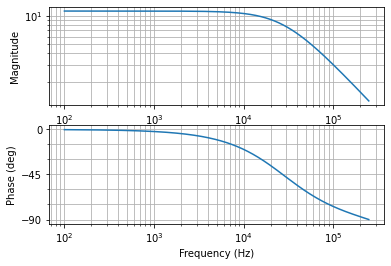

In [7]:
# control voltage to inductor current transfer function
mag, phase, omega = control.bode_plot(iLvC, omega_limits=(100, fsw / 2), Hz=True)

# Output Capacitance Impedance

Designing the output capacitance (and the error amplifier compensation network) of a switch-mode power converter is an iterative process focused on achieving two distinct performance goals:

1. Low steady-state voltage ripple is achieved by selecting capacitors which minimize the output impedance at the switching frequency. These are usually smaller (high bandwidth) ceramic capacitors (low series resistance).
2. Low voltage overshoot/undershoot in response to load step transients is achieved by increasing the amount of bulk capacitance. These are usually larger (low bandwidth) tantalum capacitors (high series resistance).

The response speed (rise time, settling time) is determined by the loop gain's crossover frequency. The loop gain's phase margin determines the amount of overshoot and ringing in the response. The designer will have to determine how to balance higher crossover frequency with larger phase margin; increasing one will often reduce the other.

Selecting the voltage ripple and transient response specifications you are designing for depends on what is required by the load. Voltage ripple is a fundamental source of conducted noise; a load step transient response that is too large may result in overvoltage/undervoltage to the downstream loads.

The [Keysight E36300](https://www.keysight.com/us/en/assets/7018-05629/data-sheets/5992-2124.pdf) is a popular generic mid-size power supply capable of 2mVpp ripple and a 15mV settling band given a 5A load step (50us time to recover). We will aim for something a bit more modest with 10mVpp and a 100mV settling band for a 2.5A load step.

The target crossover frequency is generally recommended to be 1/10 the switching frequency to avoid any loop gain interaction with the sample-and-hold effect. We will be more aggressive and aim for a crossover at the 1/6 the switching frequency. The response time should be about 50us.

## Ripple Capacitance

Let's use ceramic capacitors from the following commercial series: [AVX X7R MLCC](https://datasheets.kyocera-avx.com/X7RDielectric.pdf). It's worth keeping in mind that the effective capacitance changes as a function of voltage, temperature and frequency; the final effective series inductance and resistance will depend on the PCB layout. Capacitor voltage ratings in particular are selected to be atleast 4x the DC operating point, otherwise the loop gain is designed to have significant stability margin in order to allow for these component variations.

Let's plot a few capacitor impedances; the datasheet unfortunately doesn't provide much detail on capacitor series resistance and self-resonant frequency. Instead we can use the [KEMET KSIM tool](https://ksim3.kemet.com/capacitor-simulation) to view a chart of a similar capacitor's impedance over frequency. It's worth including small capacitors with high-resonant frequencies in order to sink any high-frequency noise due to the switching frequency harmonics.

In [8]:
def cercap(c, esr, srf):
    esl = (1 / (srf * math.tau)) ** 2 / c
    return control.tf(1, [c, 0]) + control.tf([esl, 0], 1) + esr

In [9]:
cap1n = cercap(c=1e-9, esr=260e-3, srf=260e6)  # 0805, 1nF, 200V
cap2n2 = cercap(c=2.2e-9, esr=180e-3, srf=200e6)  # 0805, 2.2nF, 200V
cap10n = cercap(c=10e-9, esr=60e-3, srf=65e6)  # 0805, 10nF, 100V
cap47n = cercap(c=47e-9, esr=43e-3, srf=40e6)  # 0805, 47nF, 100V
cap100n = cercap(c=100e-9, esr=25e-3, srf=20e6)  # 0805, 100nF, 50V
cap1u = cercap(c=1e-6, esr=20e-3, srf=9e6)  # 0805, 1uF, 25V
cap10u = cercap(c=10e-6, esr=4e-3, srf=1.3e6)  # 1206, 10uF, 16V

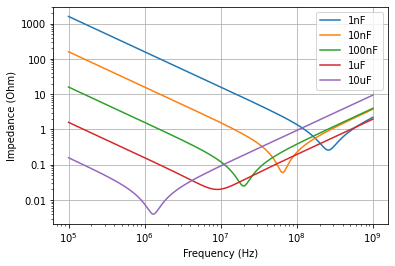

In [10]:
freq = np.logspace(5, 9, 1000)  # 100kHz to 1Ghz

z1n, _, _ = control.freqresp(cap1n, freq * math.tau)
z10n, _, _ = control.freqresp(cap10n, freq * math.tau)
z100n, _, _ = control.freqresp(cap100n, freq * math.tau)
z1u, _, _ = control.freqresp(cap1u, freq * math.tau)
z10u, _, _ = control.freqresp(cap10u, freq * math.tau)

plt.loglog(freq, z1n, label="1nF")
plt.loglog(freq, z10n, label="10nF")
plt.loglog(freq, z100n, label="100nF")
plt.loglog(freq, z1u, label="1uF")
plt.loglog(freq, z10u, label="10uF")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

In [11]:
def parz(*args):
    if len(args) == 1:
        return args[0]
    else:
        z1 = args[0]
        z2 = parz(*args[1:])
        zpar = z1 * z2 / (z1 + z2)
        return control.minreal(zpar, verbose=False)

Voltage Ripple: 4.9 mV


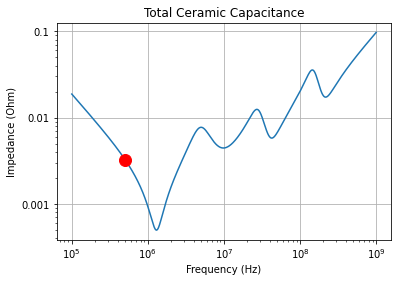

In [12]:
final_cercap = parz(cap10u / 8, cap1u / 4, cap47n / 6, cap2n2 / 8)

zfinal_cercap, _, _ = control.freqresp(final_cercap, freq * math.tau)
zripple = np.interp(fsw, freq, zfinal_cercap)

plt.loglog(freq, zfinal_cercap)
plt.plot(fsw, zripple, "ro", markersize=12)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Total Ceramic Capacitance")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

vripple = iripple * zripple
print("Voltage Ripple: {:0.1f} mV".format(vripple * 1e3))

## Bulk Capacitance

The amount of bulk capacitance required can be estimated by the load step current and the recovery time. Be mindful when selecting tantalum capacitors; manufacturers have a variety of series and case sizes that can result in series resistance ratings spanning an entire order of magnitude.

In [13]:
crossover_freq = fsw / 6
recovery_time = 4 / crossover_freq
load_step = iout / 2
vout_transient = 100e-3
bulk_target = load_step * recovery_time / vout_transient
print("Target Bulk Capacitance: {:1.0f} uF".format(1e6 * bulk_target))

Target Bulk Capacitance: 1200 uF


In [14]:
def tantcap(c, esr):
    return control.tf(1, [c, 0]) + esr

In [15]:
cap47u = tantcap(47e-6, 500e-3)  # AVX TAJC476K016RNJ
cap68u = tantcap(68e-6, 200e-3)  # AVX TPSC686K016R0200
cap100u = tantcap(100e-6, 125e-3)  # AVX TPSD107K016R0125
cap220u = tantcap(220e-6, 500e-3)  # KEMET T491X227K016AT

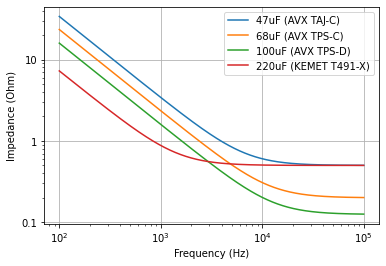

In [16]:
freq = np.logspace(2, 5, 1000)  # 100Hz to 100kHz

z47u, _, _ = control.freqresp(cap47u, freq * math.tau)
z68u, _, _ = control.freqresp(cap68u, freq * math.tau)
z100u, _, _ = control.freqresp(cap100u, freq * math.tau)
z220u, _, _ = control.freqresp(cap220u, freq * math.tau)

plt.loglog(freq, z47u, label="47uF (AVX TAJ-C)")
plt.loglog(freq, z68u, label="68uF (AVX TPS-C)")
plt.loglog(freq, z100u, label="100uF (AVX TPS-D)")
plt.loglog(freq, z220u, label="220uF (KEMET T491-X)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

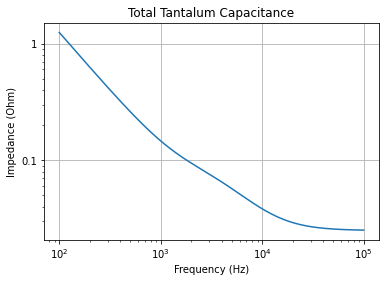

In [17]:
final_tantcap = parz(cap220u / 4, cap100u / 4)

zfinal_tantcap, _, _ = control.freqresp(final_tantcap, freq * math.tau)

plt.loglog(freq, zfinal_tantcap)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Total Tantalum Capacitance")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

# Loop Gain Compensation

48512.347636488696

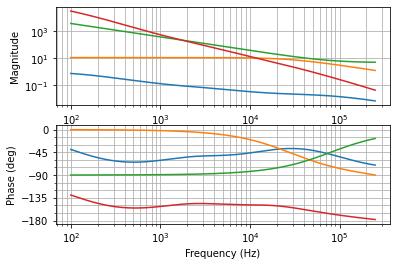

In [148]:
rload = vout / iout
total_load = parz(final_cercap, final_tantcap, rload)

gdiv = vfb / vout
# chf = control.tf(1, [39e-12, 0])  # placeholder
ccomp = control.tf(1, [10e-12, 0])  # placeholder
rcomp = 200e3  # placeholder
compensation = gdiv * gm * (rcomp + ccomp)

loop = iLvC * total_load * compensation

_, _, _ = control.bode_plot(total_load, omega_limits=(100, fsw / 2), Hz=True)
_, _, _ = control.bode_plot(iLvC, omega_limits=(100, fsw / 2), Hz=True)
_, _, _ = control.bode_plot(compensation, omega_limits=(100, fsw / 2), Hz=True)
mag, phase, omega = control.bode_plot(loop, omega_limits=(100, fsw / 2), Hz=True)

wgc = interp1d(mag, omega)(1)
wgc / math.tau

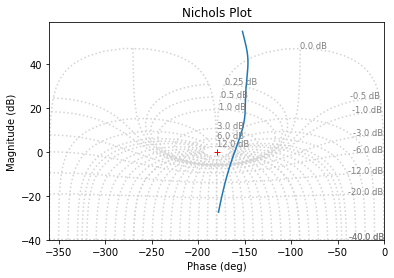

In [147]:
freq = math.tau * np.logspace(3, np.log10(fsw / 2), 1000)  # 100Hz to 100kHz
control.nichols_plot(loop, omega=freq)

# Signal Injection Transformer

A true signal injection transformer with flat amplitude over a wideband is expensive (more expensive than it should be; it's just a big ferrite core packaged in a nice box). There are a number of blogs which discuss repurposing transformers intended for other applications as a cheaper alternative ([Maxim Integrated](https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3245.html), [Electronic Projects for Fun](https://electronicprojectsforfun.wordpress.com/injection-transformers/)).

The following image is from [Mini-Circuits application note AN20-001](https://www.minicircuits.com/app/AN20-001.pdf). It shows the lumped parasitic model of a transformer. The following analysis only considers the magnetizing inductance (Lp) and primary winding resistance (R1), as these are the only parasitic values provided on the [PE-51687NL](https://www.digikey.com/en/products/detail/pulse-electronics-power/PE-51687NL/2266077?s=N4IgTCBcDaIAoFEC0BWAjANgBwHYByAMiALoC%2BQA) datasheet.

<img src="images/transformer_parasitic_model.png">

Note that for this signal injection application, the current sense transformer will be used in the reverse direction. The datasheet's "secondary" will be our "primary".

In [18]:
Lp = 20e-3  # primary magnetizing inductance
R1 = 1.4  # primary winding resistance
n = 10 / 100  # 100-turn primary, 10-turn secondary
Rsrc = 25  #  primary drive, 50 Ohm series with 50 Ohm in shunt
Rload = 22  # secondary burden

In [19]:
tf_Lp = control.tf([Lp, 0], 1)  # s-domain, s * Lp
Rload_xfmr = Rload / n ** 2  # primary reflected burden
tf_Lp_Rload_xfmr = tf_Lp * Rload_xfmr / (tf_Lp + Rload_xfmr)  # tf_Lp // Rload_xfmr
xfmr_vp = tf_Lp_Rload_xfmr / (Rsrc + R1 + tf_Lp_Rload_xfmr)  # primary winding voltage
xfmr_vs = xfmr_vp * n  # secondary winding voltage

In [20]:
cutoff_frq = -control.pole(xfmr_vs)[1] / math.tau
dcgain = control.dcgain(xfmr_vs)
wbgain = np.abs(control.evalfr(xfmr_vs, 100 * cutoff_frq * math.tau))

print("DC Gain: {:0.2f} V/V".format(dcgain))
print("Wideband Gain: {:0.2f} V/V".format(wbgain))
print("Cutoff Frequency: {:0.0f} Hz".format(cutoff_frq))

DC Gain: 0.00 V/V
Wideband Gain: 0.10 V/V
Cutoff Frequency: 208 Hz


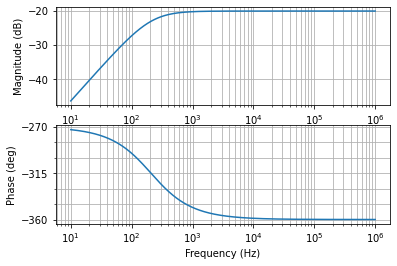

In [21]:
mag, phase, omega = control.bode_plot(xfmr_vs, omega_limits=(10, 1e6), Hz=True, dB=True)

In [22]:
vt_limit = 100 * 600e-6 / n  # volt-time product, bipolar
frq_limit = cutoff_frq / 100  # arbitrary
vt_gain = control.evalfr(xfmr_vp, frq_limit * math.tau) / frq_limit
vsrc_limit = np.abs(vt_limit / vt_gain / 2)  # square half-wave

print("Vsrc Limit (Volt-Time Product): {:0.1f} V".format(vsrc_limit))
# conclusion: transformer would overheat long before core saturation

Vsrc Limit (Volt-Time Product): 63.7 V
